In [1]:
import api
import torch
import torch.nn as nn
import matplotlib.pyplot as plt          
from sklearn.model_selection import train_test_split  
from sklearn.datasets import make_classification
import torch.optim
from collections import Counter
from matplotlib import pyplot
from numpy import where
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

*task 1*

In [2]:
#model for class Network
def create_model(input_var, output_var, hidden1, hidden2):
    model = nn.Sequential(
            nn.Linear(input_var, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_var),
            nn.Sigmoid())
    return model

In [3]:
model = create_model(2, 1, 3, 4)

In [4]:
#initiating model for Network class
net = api.NetworkBayesWrapper(model, 0.1)
net

NetworkBayesWrapper(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [5]:
input_data = torch.Tensor([5, 1])
net.mean_forward(input_data, 100)

{'mean': 0.426, 'std': 0.06}

*task 2* *first dataset*

In [6]:
#create Custom Dataset   
class CustomDataset(Dataset):
    def __init__(self, 
                 data: torch.Tensor,
                 target: torch.Tensor):
        
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, 
                    idx: int):
        
        x = self.data[idx]
        y = self.target[idx]
        return x, y

In [7]:
#create classic NN
class FeedForwardNetwork(nn.Module):
    def __init__(self, 
                 layer_sizes: int):
        
        super().__init__()
        self.layer_sizes = layer_sizes
        self.layers = nn.ModuleList()
        for i, _ in enumerate(self.layer_sizes):
            if i == len(self.layer_sizes) - 1:
                break
            self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
        
    def forward(self, x):
        x = x.reshape(-1, self.layer_sizes[0])
        for i in range(0, len(self.layers)-1):
            x = F.relu(self.layers[i](x))
        x = torch.sigmoid(self.layers[-1](x))
        return x

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True

In [8]:
#train classic nn
def train(net: FeedForwardNetwork, 
          train_epochs: int, 
          train_dataloader: DataLoader, 
          optimizer: torch.optim):
    
    losses = list()
    train_accuracies = list()
    best_accuracy = 0.0

    for epoch in range(train_epochs):
        net.train()
        for batch_idx, (data, target) in enumerate(train_dataloader):
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = F.binary_cross_entropy_with_logits(outputs, target, size_average=False)
            loss.backward()
            optimizer.step()
            losses.append(loss.clone().detach().numpy())
            # Check training accuracy
            binary_predictions = (outputs>0.5).float()
            accuracy = (binary_predictions == target).float().mean()
            train_accuracies.append(accuracy)
            
    return losses, train_accuracies

In [9]:
#check accuracy
def check_accuracy(net: FeedForwardNetwork, 
                   test_dataloader: DataLoader):
    
    net.eval()
    net.freeze()

    test_accuracies = list()
    for batch_idx, (data, target) in enumerate(test_dataloader):
        predictions = net(data)
        binary_predictions = (predictions>0.5).float()
        correct = (binary_predictions == target).float().mean()
        test_accuracies.append(correct.detach().numpy())
    return np.mean(test_accuracies)

In [10]:
#creating first dataset with clearly separated classes
X = torch.rand(2500,2)                       
Y = (torch.sum((X - 0.5)**2, axis=1) < 0.1).float().view(-1,1)

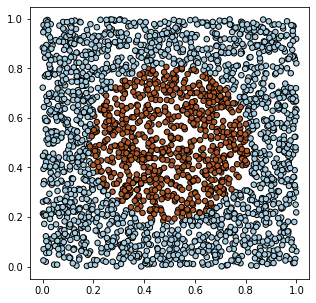

In [11]:
plt.figure (figsize=(5, 5))                                  
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy()[:,0], 
            s=30, cmap=plt.cm.Paired, edgecolors='k')        
plt.show()  

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [13]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)

In [15]:
TRAIN_EPOCHS = 100

layer_sizes = [2, 4, 9, 16, 9, 4, 1]
net_dataset = FeedForwardNetwork(layer_sizes)

optimizer = torch.optim.SGD(net_dataset.parameters(), lr=0.01)
losses, train_accuracies = train(net_dataset, TRAIN_EPOCHS, train_dataloader, optimizer)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [36]:
print('dataset train set accuracy: {}'.format(check_accuracy(net_dataset, train_dataloader)))
print('dataset test set accuracy: {}'.format(check_accuracy(net_dataset, test_dataloader)))

dataset train set accuracy: 0.7118749618530273
dataset test set accuracy: 0.684999942779541


In [37]:
#saving model
Path = './dataset0.pth'
torch.save(net_dataset.state_dict(), Path)

In [38]:
#upload first training model
net_dataset.load_state_dict(torch.load(Path))

<All keys matched successfully>

In [39]:
model = net_dataset.eval()
net = api.NetworkBayesWrapper(model, 0.1)
net

NetworkBayesWrapper(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [40]:
input_data = torch.Tensor([0.1, 0.1])
net.mean_forward(input_data, 10)

{'mean': 0.027, 'std': 0.057}

*task 2* *second dataset*

In [41]:
#creating dataset with mixed classes
X1, Y1 = make_classification(n_samples=1200, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.6], flip_y=0, random_state=1)
X1 = torch.Tensor(X1)
Y1 = torch.Tensor(Y1)

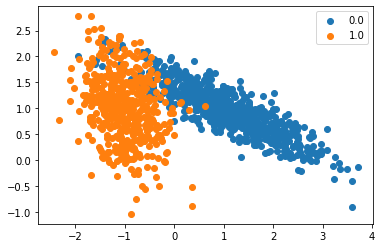

In [42]:
counter = Counter(Y1.numpy())
for label, _ in counter.items():
	row_ix = where(Y1.numpy() == label)[0]
	pyplot.scatter(X1.numpy()[row_ix, 0], X1.numpy()[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [43]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1.view(-1,1), test_size=0.33, random_state=42)

In [44]:
train_dataset1 = CustomDataset(X1_train, y1_train)
test_dataset1 = CustomDataset(X1_test, y1_test)

In [45]:
train_dataloader1 = DataLoader(train_dataset1, batch_size=100, shuffle=True, drop_last=True)
test_dataloader1 = DataLoader(test_dataset1, batch_size=100, shuffle=True, drop_last=True)

In [46]:
TRAIN_EPOCHS = 100

layer_sizes1 = [2, 4, 9, 16, 9, 4, 1]
net_dataset1 = FeedForwardNetwork(layer_sizes1)

optimizer = torch.optim.SGD(net_dataset1.parameters(), lr=0.01)

losses, train_accuracies = train(net_dataset1, TRAIN_EPOCHS, train_dataloader1, optimizer)

In [47]:
print('dataset train set accuracy: {}'.format(check_accuracy(net_dataset1, train_dataloader1)))
print('dataset test set accuracy: {}'.format(check_accuracy(net_dataset1, test_dataloader1)))

dataset train set accuracy: 0.9512500166893005
dataset test set accuracy: 0.9666666984558105


In [48]:
#saving second model
Path1 = './dataset1.pth'
torch.save(net_dataset1.state_dict(), Path1)

In [49]:
net_dataset.load_state_dict(torch.load(Path1))

<All keys matched successfully>

In [50]:
model = net_dataset.eval()
net = api.NetworkBayesWrapper(model, 0.1)
net

NetworkBayesWrapper(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [51]:
input_data = torch.Tensor([-1.5, 2])
net.mean_forward(input_data, 10)

{'mean': 0.98, 'std': 0.0}

*task 3* *first model*

In [52]:
net_dataset.load_state_dict(torch.load(Path))

<All keys matched successfully>

In [54]:
model = net_dataset.eval()
net = api.NetworkBayesWrapperBeta(model, 0.4, 0.6)
net

NetworkBayesWrapperBeta(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [55]:
input_data = torch.Tensor([0.1, 0.1])
net.mean_forward(input_data, 100)

{'mean': 0.007, 'std': 0.03}

*task 3* *second model*

In [56]:
net_dataset.load_state_dict(torch.load(Path1))

<All keys matched successfully>

In [57]:
model = net_dataset.eval()
net = api.NetworkBayesWrapperBeta(model, 0.4, 0.6)
net

NetworkBayesWrapperBeta(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [58]:
input_data = torch.Tensor([-1.5, 2])
net.mean_forward(input_data, 10)

{'mean': 0.889, 'std': 0.298}